# Final Project ML with Probabilistic Programming 
## Fall 2018, Columbia University
### Jan-Felix Schneider (jfs2160), Brian Allen (ba2542) 

# Introduction 

The spread of a contagion in a network has many applications: diseases spread through cities, news spread through media pages, behavior spread through social networks. However, the data observed in nature usually only provides the infection times and not which node infected which neighbor. 

In this project, we would like to infer an underlying "influence network" from a set of cascades, a set of node and their infection times. We're building our efforts on the work of Rodriguez et al [1], who built a probability model on the independent cascade model developed by Kempe et al [2]. Our main effort was to adapt this model to a probabilistic programming setting.

As an extension to the base, we hypothesize that cascades with added context may alter how infections spread throughout a network. For example, a viral story may spread differently if the context is politics rather than sports. 


### Given Empty Graph

In [18]:
import sys
sys.path.append('..')

from hdiffnet.utils import * 
from hdiffnet.cascade_generator import GenerativeModel
from hdiffnet.preprocessing import Preprocessing
from hdiffnet.hdiffnet import ProbabilityModel
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf
from tensorflow_probability import edward2 as ed

In [5]:
nx_graph, nx_layout, nx_weights, nx_labels = buildGraph()
default_gm = GenerativeModel(defaultAlpha(), 10)

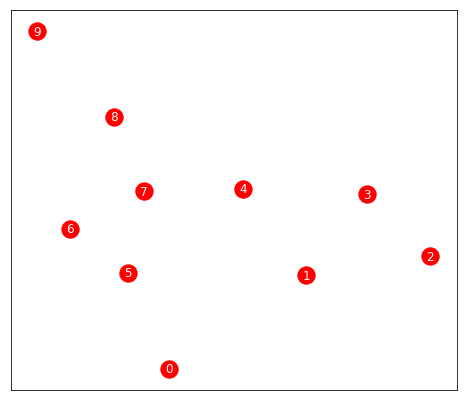

In [6]:
drawEmptyGraph(nx_graph, nx_layout, nx_labels)

### Observe Set of Cascades

node	 time
----	 ----
   0	 0.00
   5	 2.31
   1	 2.59
   6	 2.84
   7	 4.08
   8	 5.65
   2	 6.49
   3	 8.32
   4	 8.96


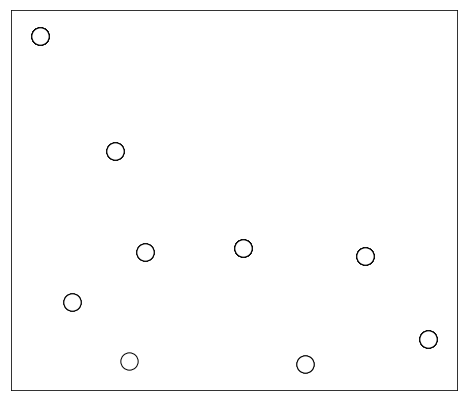

In [7]:
drawNetworkProp(nx_graph, nx_layout, nx_labels, default_gm.build_cascade(0), 10)

### Infer Network Structure

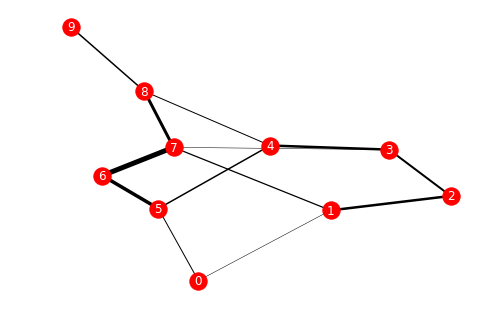

In [8]:
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)

## Base Model

### Transmission Parameters

Transmission parameters, $\alpha_{ij} > 0$ are defined for each pair of nodes as the infection rate from node $i$ to node $j$. When modeled as parameters of an Exponential distribution, the resulting set of observations $\tau$ are interarrival times of infections from node $i$ to $j$.

As an extension, we incorporate an Exponential prior on each $\alpha_{ij}$ to incorporate prior knowledge about the underlying network. 

### Cascade Likelihood

All work on inferring diffusion networks (Rodriguez et al [1]) defines a cascade likelihood function and estimates the MLE of the transmission parameters. The log-likelihood they use is:

$p(C=c) = \Pi_{t_i \leq T} \Pi_{t_m > T} S(T|t_i, \alpha_{i,m}) \cdot \Pi_{t_j > t_i} S(t_i|t_j, \alpha_{j,i}) \sum_{t_j < t_i} H(t_i| t_k, \alpha_{k,i})$

This can be calculated with a series of tensor operations. However, this likehlihood does not lend itself to a pure generative model and is difficult to incorporate into Edward's framework.

Further derivations can be found in the [paper](http://snap.stanford.edu/class/cs224w-readings/rodriguez11diffusion.pdf) 

### Cascade Seed

Each cascade must have a starting point. Since this is an input into the cascade generative process, we draw a random cascade seed $S$ from a categorical distribution assuming all seeds are equally likely.

### Generative Model

- For each node pair $(i,j)$:
    - Draw $\alpha_{ij}\sim$ Exp$(1)$
- For each cascade:
     - For each node pair $(i,j)$:
        - Draw infection times $\tau_{ij}\sim$ Exp$(\alpha_{ij})$
     - Draw cascade seed $S\sim $Cat$(\delta)$
     - Observe the shortest path $C\sim $Shortest Path$(\tau,S)$

### Graphical Model

<img src="../illustrations/model_with_prior.png" alt="drawing" style="width:500px;"/>

### Parameter Estimation

Coding shortest path as a generative model was outside the scope of our work, since it is not clear this is a differentiable procedure. In order to work around generating shortest path cascades, we then used cascade likelihood as the likelihood of the entire cascade plate. Coding a new random variable class for the cascade proved to be difficult in the amount of time for this project, which limited the parameter estimation procedures to MAP estimation. However, once the random variable class is built, inference can be expanded to the suite of tools used for probabilistic machine learning (e.g. CAVI, BBVI, MCMC, etc.)

## Cascade Topic Model

### Cascade Topic Assignment

Each cascade draws a topic assignment $Z$ from $K$ topics, with a predefined categorical probabilities $\theta$. For this model, $Z$ is a one-hot encoded vector, however it is trivial to extend the model to incorporate cascades with a mixture of topics.

### Transmission Parameters

In this model,  the $\alpha$ parameter is broken into $\alpha_0$ and $\alpha_1$. For a given cascade, define $\alpha = $Relu$(\alpha_0+\alpha_1 \cdot Z)$, where $\alpha_0$ acts as a $NxN$ intercept and $\alpha_1$ is a $NxNxK$ tensor where $k^{th}$ $NxN$ slice is activated when $Z=k$. This $\alpha_1$ parameter captures the polarity the node has for the given topic. A high similarity between the nodes polarity and the topic assignment, the more likely transmission.

### Generative Model

- For each node pair $(i,j)$:
    - Draw $\alpha_0\sim$ Exp$(1)$
    - For each topic:
        - Draw $\alpha_1\sim$ Exp$(1)$
- For each cascade:
     - Draw topic assignment $Z\sim$ Cat$(\theta)$:
     - For node pair $(i,j)$:
        - Draw infection times $\tau_{ij}\sim$ Exp$($Relu$(\alpha_0+\alpha_1\cdot Z)$$)$
     - Draw cascade seed $S\sim$ Cat$(\delta)$
     - Observe the shortest path $C\sim $Shortest Path$(\tau,S)$

### Graphical Model

<img src="../illustrations/model_with_polarity.png" alt="drawing" style="width:500px;"/>

# Data - Memetracker


The raw memetracker dataset includes a phrase, a phrase id, a related phrase cluster, the URL of a webpage and a timestamp. For our analysis, we included the top 200 webpages and labeled each phrase as a cascade. 

In order to extract topic information from the cascades, we performed string searches for common political words (e.g. "politics") and common sports words (e.g. "football") String matches label the topic as either politics-related or sports-related.

In [ ]:
#process the raw data and add topics to the cascades
p = Preprocessing("data/clust-qt08080902w3mfq5.txt")
p.preprocess_data(200)
p.add_polarity()
data = p.data

In [10]:
#load the preloaded data
data = pd.read_csv('../data/clean_data.csv')
r, topics = transform_full_to_sparse(data, topics=True)

# Base Model Inference

Due to difficulties with the Tensorflow's random variable class, we used MAP estimation with L-BFGS as the primary inference method.

In [11]:
# Feed the data into a tensorflow log-prior model.
max_T = data.t.max()
numNodes = 200
model = ProbabilityModel(r[:50], numNodes, T = max_T)

In [12]:
a_prior = model.map_estimate_BFGS(max_iter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69.646233
  Number of iterations: 57
  Number of functions evaluations: 111


In [ ]:
# Batch updates for the whole dataset
a_prior = model.batch_update(batch_size=400)


# Cascade Topic Model Inference

The cascade model is trained on two topics.

In [13]:
# Feed the data into a tensorflow log-prior model.
max_T = data.t.max()
numNodes = 200
model_topic = ProbabilityModel(r[:50], numNodes, T=max_T, topics=topics[:50])

In [14]:
a_topic = model_topic.map_estimate_BFGS_topics(max_iter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 721899.187500
  Number of iterations: 44
  Number of functions evaluations: 202


# Base Model Criticism

We compare cascade samples from a random graph cascade draws from the inferred graph and calculated by generating a cascade. The metrics include,

* MSE and MAE: how good can we predict infection times 
* Kendall rank corellation coefficient: how good can we predict infection order 
* Precision: how good can we predict the cascade set


In [15]:
# get test set and observable variables
test_set = r[-5:]
seeds = get_seed_set(test_set)
times = get_max_times(test_set)
test_set = convert_to_matrix(test_set, numNodes, times)
test_topics = topics[-5:,:]

In [16]:
# generate cascades with the learned parameters
gm = GenerativeModel(model.a, numNodes)
test_cascades = gm.build_cascade_series(seeds, times)

In [19]:
# generate a benchmark cascade according to the seed set
sess=tf.Session()
alpha = ed.Gamma(tf.ones((numNodes,numNodes)),tf.ones((numNodes,numNodes)))
a_bench = sess.run(alpha)

gm = GenerativeModel(a_bench, numNodes)
benchmark_cascades = gm.build_cascade_series(seeds, times)

In [20]:
evaluate(test_set, test_cascades, benchmark_cascades, times)

metric	 set	 	 value
_______|_____________|______________________
MSE	 benchmark	13494.0
MSE	 model  	758.0
MAE	 benchmark	99.0
MAE	 model  	5.0
KRCC 	 benchmark	0.037
KRCC 	 model  	0.773
Prec	 benchmark	0.042
Prec	 model  	0.156


#  Cascade Topic Criticism

In [21]:
# generate cascades according to the seed set
gm = GenerativeModel(a_topic, numNodes)
test_cascades_t = gm.build_topic_cascades(seeds, times, test_topics)

In [22]:
evaluate(test_set, test_cascades_t, benchmark_cascades, times)

metric	 set	 	 value
_______|_____________|______________________
MSE	 benchmark	13494.0
MSE	 model  	972.0
MAE	 benchmark	99.0
MAE	 model  	7.0
KRCC 	 benchmark	0.037
KRCC 	 model  	0.725
Prec	 benchmark	0.042
Prec	 model  	0.068


# Issues with Edward

## Non-Differentiability of Shortest Path

Our struggle with Edward is concentrated in defining the shortest path operation on the transmission times. Since this is operation is non-differentiable, most inference methods break. There is some work on estimating shortest path using an RNN, which we may explore.

## Issues with Random Variable Class

We transitioned from working with generating a shortest path to evaluating the log-probability of the cascade. Within Edward, we can define a new random variable class that requires the log-probability and sampling distribution. This was time-consuming and difficult to debug. So, we stopped working with Edward's random variable class and built the algorithm by manually defining the log-probability in tensorflow.


# Conclusion and Future Work

The models do a good job at fitting to the cascade dataset relative to a random graph. However, scalability may become an issue as the network grows. For future modeling work, we consider adding priors to the categorical variables and allowing for mixture topic assignments. For future criticism work, we would consider toggling hyperparameters to ensure inferred network diameter aligns with expectations.

# References

[1] Rodriguez, M. G., Balduzzi, D., & Schölkopf, B. (2011). Uncovering the temporal dynamics of diffusion networks. arXiv preprint arXiv:1105.0697.

[2] Kempe, D., Kleinberg, J., & Tardos, É. (2003, August). Maximizing the spread of influence through a social network. In Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 137-146). ACM.

[3] Amini, Hamed, and Marc Lelarge. "The diameter of weighted random graphs." The Annals of Applied Probability 25.3 (2015): 1686-1727.
